# Начнем с повторения предидущего материала - разогрев.


In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 9.8 MB 31.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

import numpy as np

In [3]:
def generate_time_series(func, size=500):
    time_step = range(size)
    series = []

    for t in time_step:
        new_observation = func(series, t)
        series.append(new_observation)
    
    plt.plot(time_step, series)
    plt.show()
    
    return series

### Зададим функции которые задают разные временные ряды, можно поменять гипер параметры и посмотреть что будет. Формальное описание функций чуть ниже.

In [4]:
def white_noise(series, t):
    return gauss(0.0, 4.0)

def noisy_trend(series, t):
    trend = 0.5
    y = t*trend + gauss(0.0, 3.0)  # noise(t)
    return y

def random_walk(series, t):
    step_size = 1
    trend = 1

    if len(series)>1 :
        s = series[-1]
    else: 
        s = 0
    return trend*s + step_size*gauss(0.0, 2.0)

На прошлом занаятии мы посмотрели на автокорреляцию как способ оценить явлется ли наш ряд стационарным. Проделаем это еще раз. 

Ваша задача теперь сказать, является ли ряд стационарным.

## Белый шум

$y \sim N(0,\sigma)$

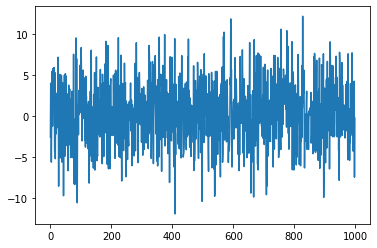

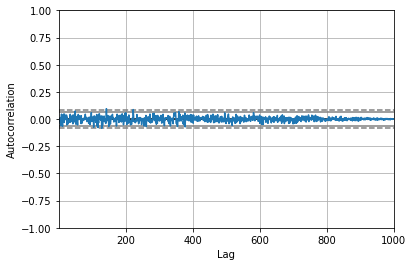

In [5]:
observations = generate_time_series(white_noise, size=1000)
autocorrelation_plot(observations)

## Тренд

$y = f(t) + \epsilon$

$\epsilon \sim N(0,\sigma)$

<br>

$y = signal + noise$

<br>

$ y_{pred} = singal $ -  идеальное предсказание, мы знаем природу сигнала $f(t)$
<br>
$ y -  y_{pred} = noise $

<br> 
- Отсюсда видно, что ошибка нашего идеального предсказания будет слуачайным шумом (в данном случае).
- Можем ли мы сделать что-то лучше?



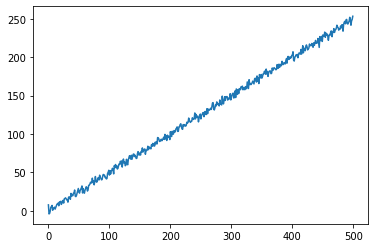

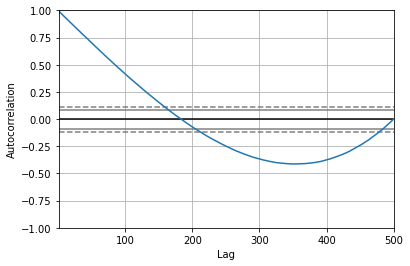

In [6]:
observations = generate_time_series(noisy_trend)
autocorrelation_plot(observations)

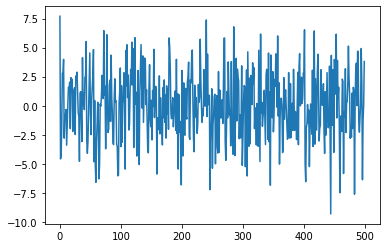

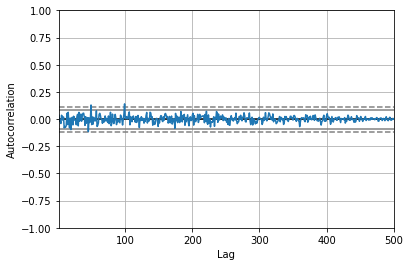

In [7]:
without_trend = []

for i in range(len(observations)):
    o = observations[i]
    y = o - i*0.5
    without_trend.append(y)

plt.plot(range(len(observations)), without_trend)
plt.show()

autocorrelation_plot(without_trend)

### Cлучайное блуждание

$y_t = b_1 + b_0*y_{t-1} + s*ϵ $

$\epsilon \sim N(0,\sigma)$

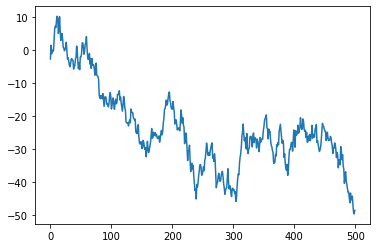

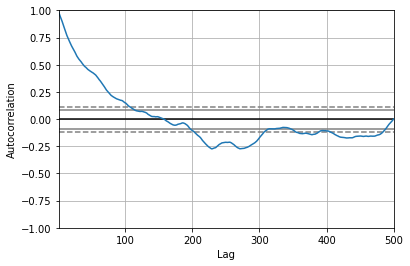

In [8]:
observations = generate_time_series(random_walk)
autocorrelation_plot(observations)

### Как предсказать radndom walk?

 - Брать последнее значение в виде предсказания.

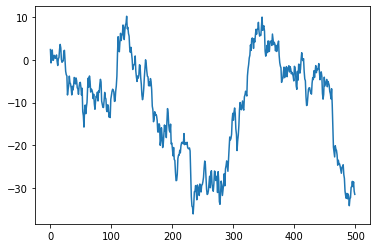

Persistence RMSE: 1.897, обратите внимание, ошибка почти равна одному из параметров нормального распределения - шума.


In [9]:
observations = generate_time_series(random_walk)

train, test = observations[0:25], observations[25:]

predictions = list()

history = observations[-1]

history = train[-1]
for i in range(len(test)):
    yhat = history
    predictions.append(yhat)
    history = test[i]
rmse = sqrt(mean_squared_error(test, predictions))
print('Persistence RMSE: %.3f, обратите внимание, ошибка почти равна одному из параметров нормального распределения - шума.' % rmse)

## Можем ли мы сделать что-то лучше?

### Еще в прошлый раз мы видели, что модели могут состоять из разных компонент.

$y = level + trend + seasanobilty + noise $
<br>
$y = level * trend * seasanobilty * noise $ - не линейная связь тоже возможна

<br> Пример не линейной связи:

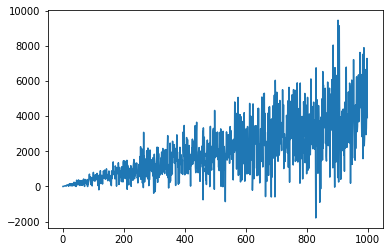

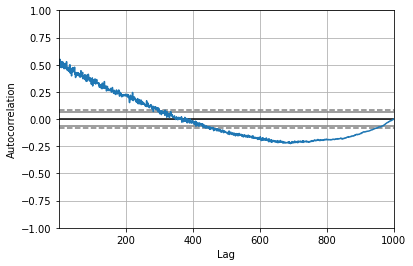

In [10]:
def noisy_trend_prod(series, t):
    trend = 2
    y = t*trend*gauss(2.0, 1.0)
    return y

observations = generate_time_series(noisy_trend_prod, size=1000)
autocorrelation_plot(observations)

# ARMA & ARIMA
- AR: Autoregressive
- I: Integrated  
- MA: Moving Average 

# Autoregressive

$ X_{t+1} = θ_0 + X_t* θ_1 + X_{t-1} * θ_2 ... X_{t-n} * θ_{n-1}$
Вопрос: откуда название авторегрессионная модель?

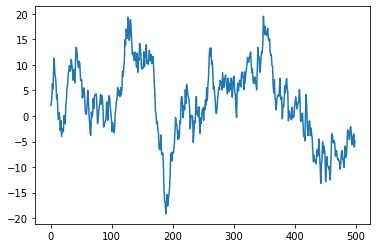

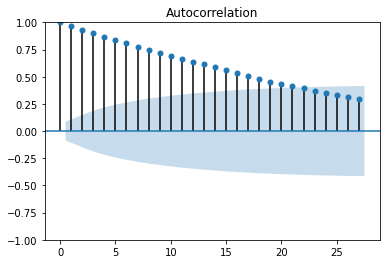

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

observations = generate_time_series(random_walk)

plot_acf(Series(observations));

# все что за рамками синего имеет большую стат значимость, все что внутри малеьнкую

## AR модель своими руками

In [12]:
from sklearn.linear_model import LinearRegression as LR
  
lr = LR()

# лаги, делим датасет на несколько частей и предсказываем кадждую последующую точку чепез n шагов
def make_lags(data: list(), p):
    features = []
    y = []

    for i in range(p,len(data)-1,1):
        if len(data) > i+p+1:
            features.append(data[i:i+p])
            #print(data[i:i+p])
            y.append(data[i+p+1])

    return np.array(features), np.array(y)


def AR(train, test, p):
    
    train_p, y_train = make_lags(train, p)
    test_p, y_test = make_lags(test, p)

    lr.fit(train_p, y_train)
    
    preds = lr.predict(test_p)
    preds_train = lr.predict(train_p)
    
    
    return preds, y_test, preds_train, y_train

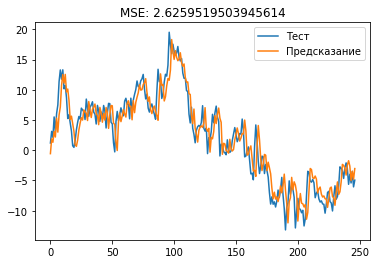

In [13]:
# надо попробовать разные параметры p - чилос лагов
# обычно такие такие параметры подбираются руками, но в нашем случае мы можем попрбовать сделать это на глаз

size = len(observations)

train, test = observations[:size//2], observations[size//2:]

p = 1

preds, y_test, preds_train, y_train = AR(train, test, p)


plt.plot(range(len(y_test)), y_test,   label=f"Тест")
plt.plot(range(len(preds)), preds, label=f"Предсказание")

plt.title(f'MSE: {sqrt(mean_squared_error(y_test, preds))}')
plt.legend();

### Cравните результат с предсказанием предидущим значением выше, что лучше?

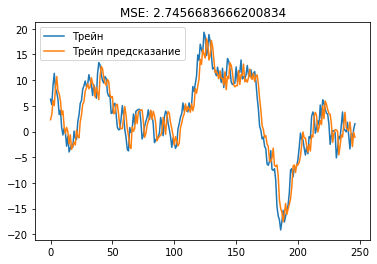

In [14]:
plt.plot(range(len(y_train)), y_train,   label=f"Трейн")
plt.plot(range(len(preds_train)), preds_train, label=f"Трейн предсказание")
plt.title(f'MSE: {sqrt(mean_squared_error(y_train, preds_train))}')
plt.legend();

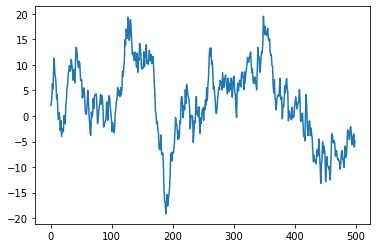

In [15]:
# Посмотрим на все данные еще раз
plt.plot(range(len(observations)), observations)

### То же самое, но для другого набора данных.

Все-таки почему нужно пытаться привести ряд к стационарному.

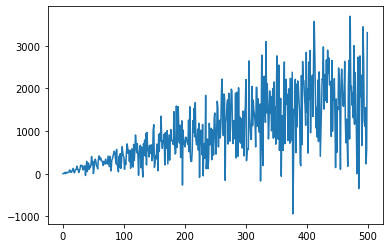

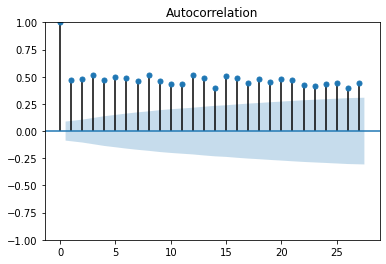

In [ ]:
observations = generate_time_series(noisy_trend_prod,size=500)

plot_acf(Series(observations));

# все что за рамками синего имеет большую стат значимость, все что внутри - меньшую

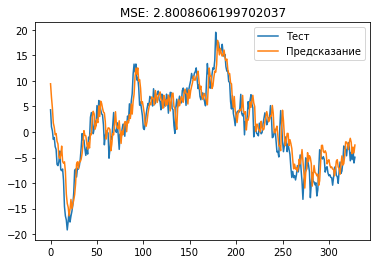

In [16]:
size = len(observations)

train, test = observations[:size//3], observations[size//3:]

p = 2

preds, y_test, preds_train, y_train = AR(train, test, p)


plt.plot(range(len(y_test)), y_test,   label=f"Тест")
plt.plot(range(len(preds)), preds, label=f"Предсказание")

plt.title(f'MSE: {sqrt(mean_squared_error(y_test, preds))}')
plt.legend();

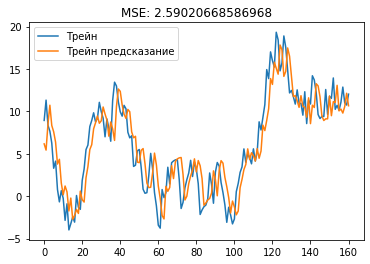

In [17]:
plt.plot(range(len(y_train)), y_train,   label=f"Трейн")
plt.plot(range(len(preds_train)), preds_train, label=f"Трейн предсказание")
plt.title(f'MSE: {sqrt(mean_squared_error(y_train, preds_train))}')
plt.legend();

# Moving averages or Autoregression on residuals
- Тут не надо путать со сколзящим окном, название немного контр интуитивно.
- На самом деле все что мы хотим сделать это применить туже самую модель но на ошибках предидущей модели что бы скорректировать их.

$MA =  error_{t+1} = \beta_0 + error_t*\beta_1 ... + error_n*\beta_{n-1} $ <br>
$AR =  X_{t+1} = θ_0 + X_t* θ_1 + X_{t-1} * θ_2 ... X_{t-n} * θ_{n-1}1$ <br>
$Y_{predicted} = MA + AR$ <br>

Совместив эти две модели мы получаем модель ARMA, еще не ARIMA, но мы уже близко.

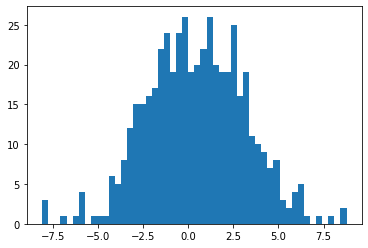

In [18]:
# Cчитаем ошибку 

residuals  = np.concatenate([preds_train, preds]) - np.concatenate([y_train, y_test])


# Cамо собой нам нравится распределение нашей ошибки
plt.hist(residuals,bins=50);

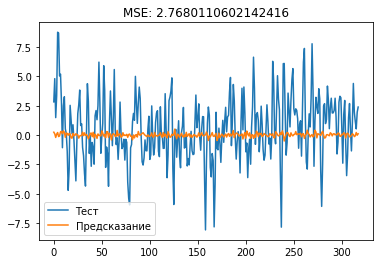

In [19]:
q = 4

size = len(residuals)

r_train, r_test = residuals[:size//3], residuals[size//3:] 

preds_residual, y_test_residual, _, _ = AR(r_train, r_test, q)


plt.plot(range(len(y_test_residual)), y_test_residual,   label=f"Тест")
plt.plot(range(len(preds_residual)), preds_residual, label=f"Предсказание")

plt.title(f'MSE: {sqrt(mean_squared_error(y_test_residual, preds_residual))}')
plt.legend();

### Посмотрим на тот, как обе модели работают вместе



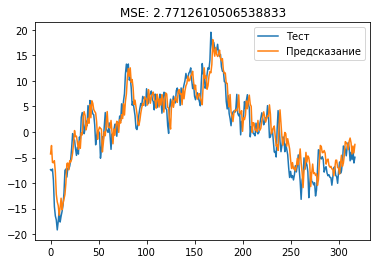

In [20]:
shift = 11

final_preds = preds[shift:] + preds_residual
 
plt.plot(range(len(y_test[shift:])), y_test[shift:],   label=f"Тест")
plt.plot(range(len(final_preds)), final_preds, label=f"Предсказание")

plt.title(f'MSE: {sqrt(mean_squared_error(y_test[shift:], final_preds))}')
plt.legend();

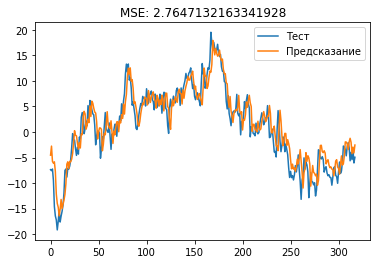

In [21]:
final_preds = preds[shift:] #+ preds_residual
 
plt.plot(range(len(y_test[shift:])), y_test[shift:],   label=f"Тест")
plt.plot(range(len(final_preds)), final_preds, label=f"Предсказание")

plt.title(f'MSE: {sqrt(mean_squared_error(y_test[shift:], final_preds))}')
plt.legend();

### Мы видим, что хоть ошибка и стала больше, теперь наши предсказания более похожи на тестовый временной ряд. При этом мы не приводили наш временной ряд к стационарному. Но пример выше хорошо показывает как работет ARMA.

<br>

## ARIMA

ARIMA это та же самая модель что и ARMA, но модель сама производит приведение ряда в стацонарный за счет смещения несколько раз.

- ARIMA(p, d, q)
- p : колличество лагов для AR
- d : differencing приведение модели к стационарному виду
- q : колличество лагов в residuals для MA модели

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(test, order=(3,1,2))
model_fit = model.fit();
#model_fit.plot_predict(dynamic=False)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


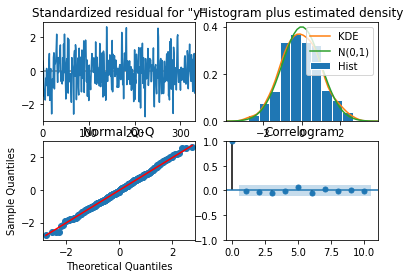

In [23]:
model_fit.plot_diagnostics();

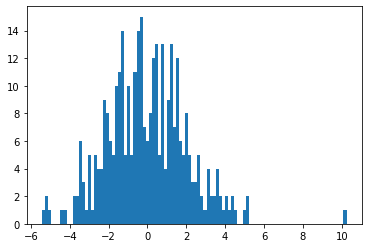

In [24]:
plt.hist(model_fit.resid, bins=100);

In [25]:
sqrt(np.mean(model_fit.resid**2))

2.053378684616366

### И это еще не все, можно воспользоваться готовым решением что бы автоматически найти все нужные параметры.

Ниже мы будем оптимизировать BIC - Bayesian information criterion, подробнее тут: https://en.wikipedia.org/wiki/Bayesian_information_criterion

In [26]:
import pmdarima as pm

In [27]:
model = pm.auto_arima(observations, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      information_criterion='bic')


Performing stepwise search to minimize bic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : BIC=2142.577, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=2109.444, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=2114.155, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=2114.034, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=2103.256, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=2119.523, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.858 seconds


In [28]:
model.resid

<function pmdarima.arima.arima.ARIMA.resid(self)>

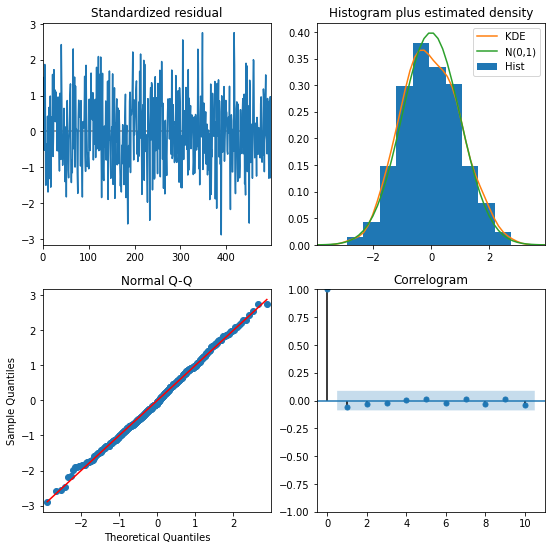

In [29]:
model.plot_diagnostics(figsize=(9,9))
plt.show()

### Q-Q плот отвечает на вопрос, насколько квантили распределения нашего датасета совпадают с распределениями модели или теоретическими распределениями.

# Заключение
- Мы повторили разные, базовые виды временных рядов и посмотрели, как их можно комбинировать
- Подробно разбрали и сами собрали по частям модель ARMА
- Получили интуицию, как подбирать параметры модели
- Рассмотрели использование готовых решений для применения этой модели